In [59]:

#files
import sys
#from os import listdir
sys.path.append('../data')
sys.path.append('../Librerias')
#from os.path import isfile, join

#own libs
import utils
import caract as dc
import dataset as ds
import generate_dataset as gd
import plotting


#data and visualization
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

sns.set_style("darkgrid")


import numpy as np
import random
import os, errno
from tqdm import tqdm

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as data_utils

In [2]:
#fpath = "/Users/consu/OneDrive/Documentos/GitHub/Tesis/data/low/"
fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/low/"
fname = "file1_050124.mat"
cutoff = [8/1000, 11/1000]

mat = ds.MatFileToDataFrame(fpath, fname)

df_ = mat.get_dataframe(cutoff)

x = dc.CaractDefect(df_)
taus = x.get_tau()[1]

hilbert, _ = x.get_hilbert()

df = pd.merge(df_, hilbert, on = 'Hilbert Transform', how = 'outer')

df.head()

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform,Amplitude,Instantaneous Phase,Gradient Phase
0,2.256644,0.049758,0.007786,0.007786-0.004629j,0.009058,-0.536394,-0.056599
1,2.258288,0.051402,0.007361,0.007361+0.000726j,0.007397,0.098350,-0.028915
2,2.260261,0.053375,0.006933,0.006933+0.001102j,0.007020,0.157607,-0.002832
3,2.260918,0.054033,0.006502,0.006502+0.003041j,0.007178,0.437517,0.020193
4,2.262233,0.055348,0.006068,0.006068+0.003316j,0.006915,0.500092,0.039028


## **dataset**

In [3]:
#split data
def split_data(dataset, split = 0.8):
    train_size =  int(len(dataset)*split)
    #test_size = len(dataset) - train_size
    train, test = dataset[:train_size], dataset[train_size:]
    return train, test

In [47]:
def create_dataset(dataset, lookback):
    X,y = [],[]
    for i in range(len(dataset)-lookback):
        X.append(dataset[i:(i+lookback)])
        y.append(dataset[i+1:i+lookback +1 ])
    X = np.array(X)
    y = np.array(y)
    if dataset.ndim == 1:
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))
        y = np.reshape(y, (y.shape[0], y.shape[1], 1))
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    else:
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [22]:
#amplitudes =  df[['Amplitude', 'Gradient Phase']][300:31000].values
amplitudes =  df['Amplitude'][300:31000].values
train, test = split_data(amplitudes)
X_train, y_train = create_dataset(train, 50)
X_test, y_test = create_dataset(test, 50)
#shape should be (window samples, lookback (time steps), features) 
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)



torch.Size([24510, 50, 1]) torch.Size([24510, 50, 1]) torch.Size([6090, 50, 1]) torch.Size([6090, 50, 1])


In [13]:
amplitudes =  df[['Amplitude', 'Gradient Phase']][300:31000].values
amplitudes.ndim

2

## **model 1**
basic a simple feature model

In [33]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size = 1,hidden_size =  50, num_layers = 1, batch_first = True)
        self.linear = nn.Linear(50,1)

    def forward(self, x):
        x, _ = self.lstm(x) # x are the hidden states, _ is the lstm memory cell
        x = self.linear(x)
        return x

## **training and testing**

In [34]:
model = AirModel()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
loss_fn = nn.MSELoss()
loader = data_utils.DataLoader(data_utils.TensorDataset(X_train, y_train), shuffle = True, batch_size = 16)


Epoch: 0, Train Loss: 1.3179733571178076e-07, Test Loss: 6.973944977062274e-08
Epoch: 0, Loss: 8.17206640135737e-08


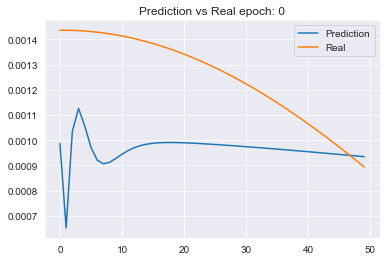

Epoch: 10, Train Loss: 9.712505244507952e-10, Test Loss: 1.511164970935397e-09
Epoch: 10, Loss: 5.185420426379039e-10


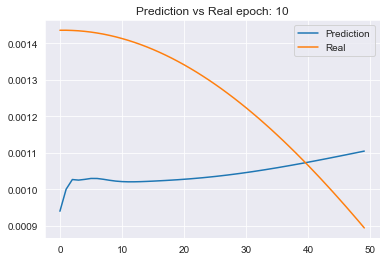

Epoch: 20, Train Loss: 2.4435296452907096e-08, Test Loss: 2.2167000679473858e-08
Epoch: 20, Loss: 1.9687718122440856e-08


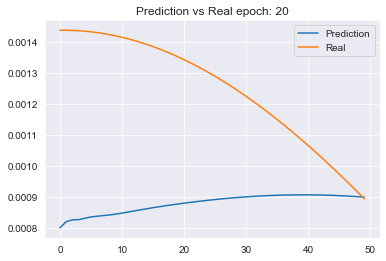

Epoch: 30, Train Loss: 4.4680689370579785e-08, Test Loss: 4.87884754818424e-08
Epoch: 30, Loss: 3.0096781955535334e-08


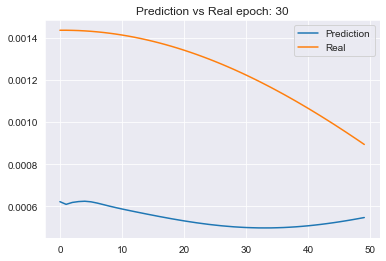

Epoch: 40, Train Loss: 1.4634843337191228e-09, Test Loss: 1.8589573214100596e-09
Epoch: 40, Loss: 1.0206148148839134e-09


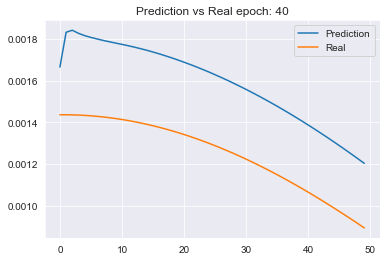

Epoch: 50, Train Loss: 1.2945598371061351e-08, Test Loss: 1.3636752171919397e-08
Epoch: 50, Loss: 1.0856656018631838e-08


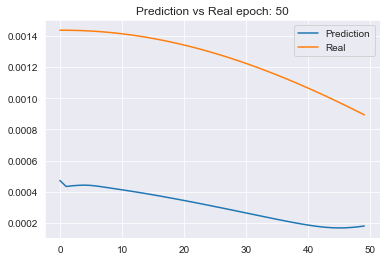

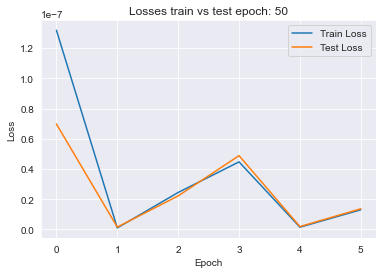

Epoch: 60, Train Loss: 2.7095918841979483e-09, Test Loss: 2.747723160112514e-09
Epoch: 60, Loss: 2.3817285921268194e-09


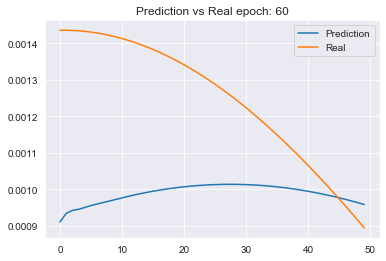

Epoch: 70, Train Loss: 2.667075449380718e-09, Test Loss: 2.4934549980315523e-09
Epoch: 70, Loss: 3.926164282574973e-09


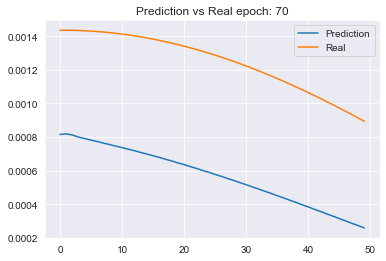

Epoch: 80, Train Loss: 5.307320805059135e-09, Test Loss: 5.7545550546933555e-09
Epoch: 80, Loss: 5.871716446392838e-09


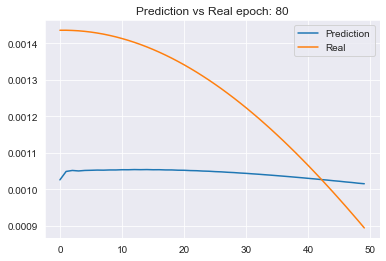

Epoch: 90, Train Loss: 1.5972514422202266e-09, Test Loss: 1.328770982134131e-09
Epoch: 90, Loss: 6.603470548149915e-10


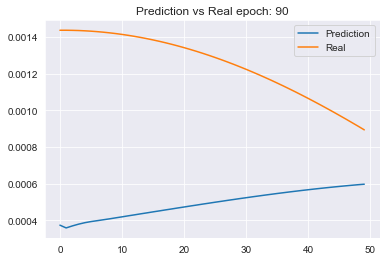

Epoch: 100, Train Loss: 3.541621884650681e-09, Test Loss: 3.6318903440246686e-09
Epoch: 100, Loss: 2.3995438969137695e-09


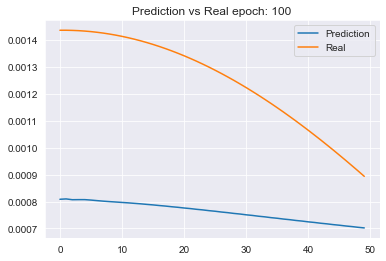

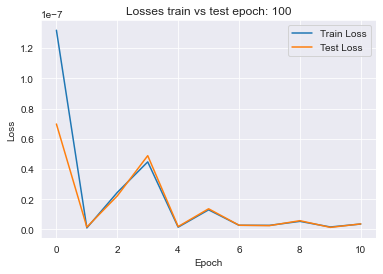

Epoch: 110, Train Loss: 1.5348406989801333e-09, Test Loss: 1.7719842260177643e-09
Epoch: 110, Loss: 3.5255900421304887e-09


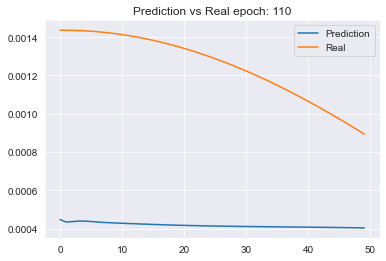

Epoch: 120, Train Loss: 1.6306593575432515e-10, Test Loss: 1.9633343562031058e-10
Epoch: 120, Loss: 1.2962686479767171e-10


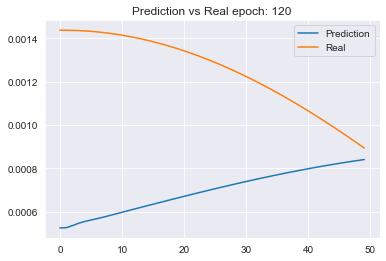

Epoch: 130, Train Loss: 6.620979875471278e-10, Test Loss: 6.689278020388656e-10
Epoch: 130, Loss: 1.2420703354720786e-09


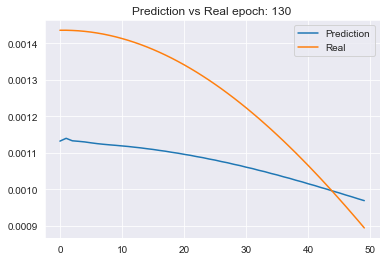

Epoch: 140, Train Loss: 6.349774039904332e-10, Test Loss: 6.260427176663086e-10
Epoch: 140, Loss: 2.0029974900914738e-10


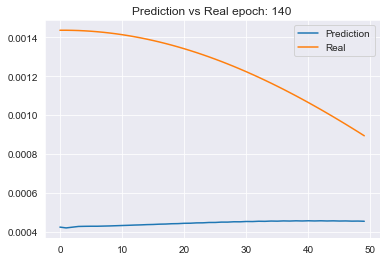

Epoch: 150, Train Loss: 2.426183143278138e-10, Test Loss: 3.584746111062742e-10
Epoch: 150, Loss: 1.7486916081832504e-10


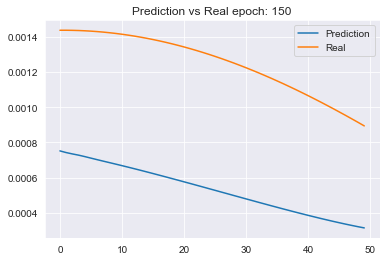

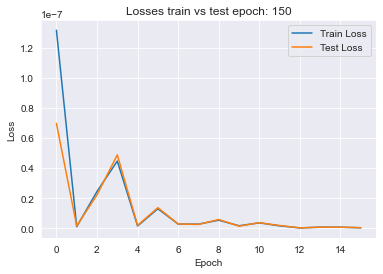

Epoch: 160, Train Loss: 6.607321911822339e-10, Test Loss: 7.523062173220296e-10
Epoch: 160, Loss: 1.783935638099976e-10


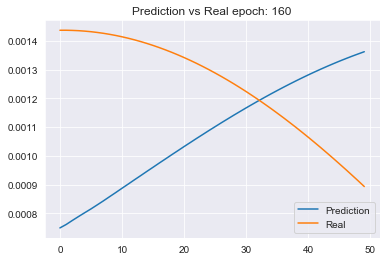

Epoch: 170, Train Loss: 1.5971998168495816e-09, Test Loss: 1.6693643134502167e-09
Epoch: 170, Loss: 1.2376888403053954e-09


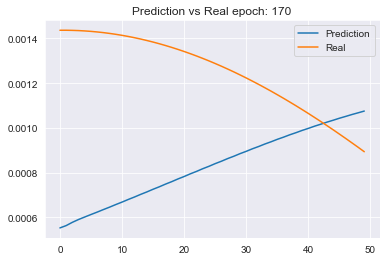

Epoch: 180, Train Loss: 1.242707270421306e-09, Test Loss: 1.6141670222680204e-09
Epoch: 180, Loss: 1.924651826801238e-10


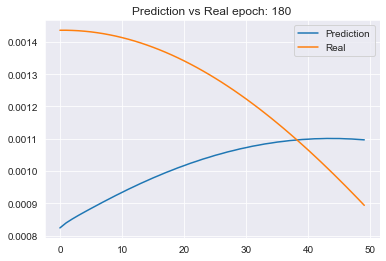

Epoch: 190, Train Loss: 1.3548404620422616e-09, Test Loss: 1.4328885855618978e-09
Epoch: 190, Loss: 1.2026708517964835e-09


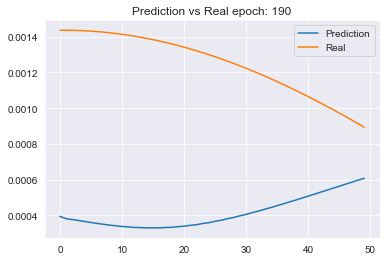

In [37]:
train_losses = []
test_losses = []

n_epochs = 200
for epoch in range(n_epochs):
    model.train()
    for x_batch, y_batch in loader:
        y_pred = model(x_batch.float())
        loss = loss_fn(y_pred, y_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    #validation
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            y_pred_train = model(X_train.float())
            train_loss = loss_fn(y_pred_train, y_train.float())
            train_losses.append(train_loss.item())
            
            y_pred_test = model(X_test.float())
            test_loss = loss_fn(y_pred_test, y_test.float())
            test_losses.append(test_loss.item())
            
            print(f'Epoch: {epoch}, Train Loss: {train_loss.item()}, Test Loss: {test_loss.item()}')
            print(f'Epoch: {epoch}, Loss: {loss.item()}')
            plt.plot(y_pred[0].numpy(), label = 'Prediction')
            plt.plot(y_test[0].numpy(), label = 'Real')
            plt.title('Prediction vs Real epoch: ' + str(epoch))
            plt.legend()
            plt.show()
            plt.close()
            
    
    if epoch % 50 == 0 and epoch != 0:
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.title('Losses train vs test epoch: ' + str(epoch))
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
        plt.close()

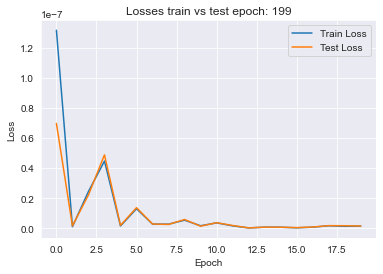

In [38]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Losses train vs test epoch: ' + str(epoch))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plt.close()

Epoch: 0, Train RMSE: 0.00026963819982483983, Test RMSE: 0.00036415658541955054
Epoch: 0, Loss: 8.953416141821435e-08


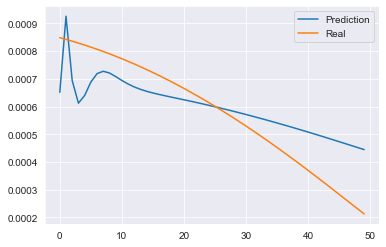

Epoch: 10, Train RMSE: 2.8143997042207047e-05, Test RMSE: 2.467707236064598e-05
Epoch: 10, Loss: 5.317821738515249e-09


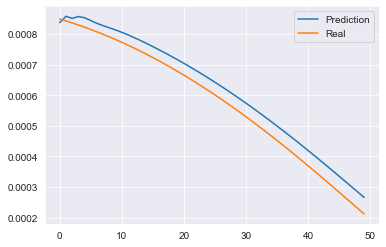

Epoch: 20, Train RMSE: 5.795431206934154e-05, Test RMSE: 5.5391221394529566e-05
Epoch: 20, Loss: 3.473108245444223e-09


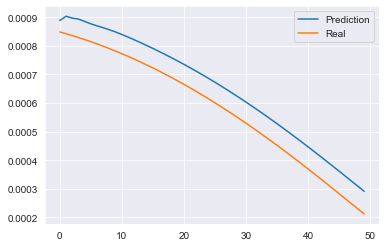

Epoch: 30, Train RMSE: 9.04690459719859e-05, Test RMSE: 9.06556160771288e-05
Epoch: 30, Loss: 1.0304634479041397e-08


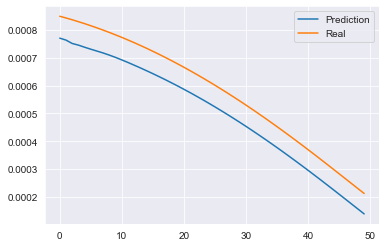

Epoch: 40, Train RMSE: 6.791627674829215e-05, Test RMSE: 6.849153578514233e-05
Epoch: 40, Loss: 3.1680509327003392e-09


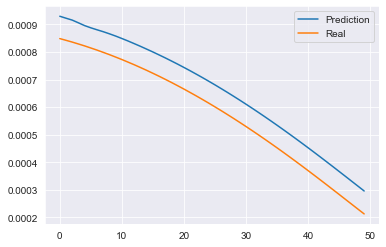

Epoch: 50, Train RMSE: 6.065958223189227e-05, Test RMSE: 5.79612678848207e-05
Epoch: 50, Loss: 1.6570012029148984e-09


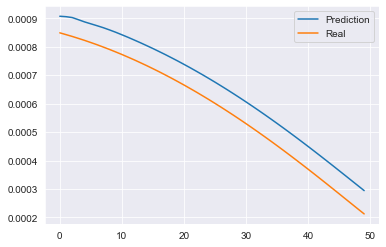

Epoch: 60, Train RMSE: 2.0863435565843247e-05, Test RMSE: 1.8913580788648687e-05
Epoch: 60, Loss: 6.82129630558137e-10


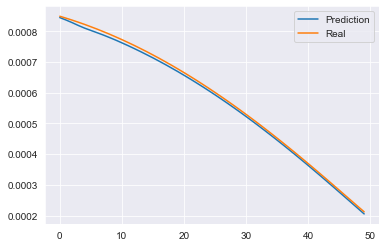

Epoch: 70, Train RMSE: 3.148057294311002e-05, Test RMSE: 3.293196277809329e-05
Epoch: 70, Loss: 1.3027988687852599e-09


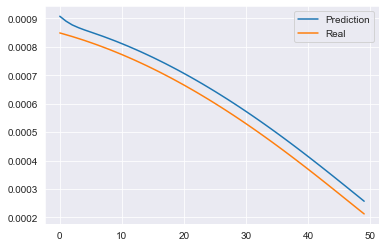

Epoch: 80, Train RMSE: 3.855900285998359e-05, Test RMSE: 3.857235424220562e-05
Epoch: 80, Loss: 8.024458320043948e-10


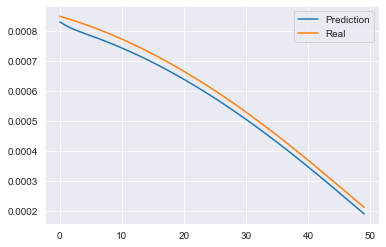

Epoch: 90, Train RMSE: 2.8849157388322055e-05, Test RMSE: 2.674854658835102e-05
Epoch: 90, Loss: 1.8068173623930761e-09


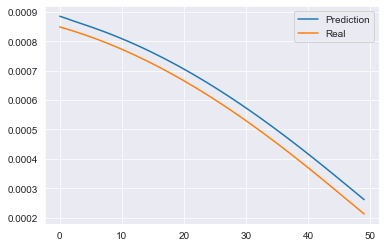

Epoch: 100, Train RMSE: 8.346686627191957e-06, Test RMSE: 8.73241060617147e-06
Epoch: 100, Loss: 2.8061036827509156e-10


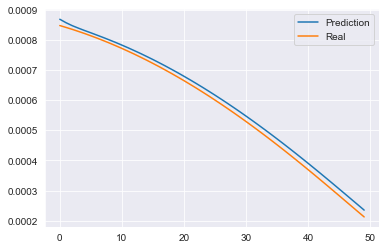

Epoch: 110, Train RMSE: 7.404426469292957e-06, Test RMSE: 8.042171430133749e-06
Epoch: 110, Loss: 7.432084947467388e-10


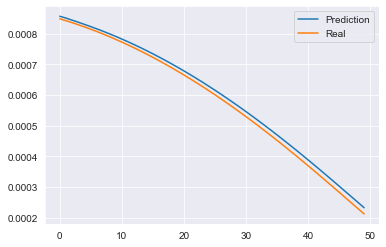

Epoch: 120, Train RMSE: 1.1479599379526917e-05, Test RMSE: 9.7780539363157e-06
Epoch: 120, Loss: 7.541504226660223e-11


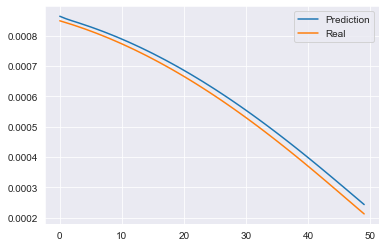

Epoch: 130, Train RMSE: 2.220743590441998e-05, Test RMSE: 2.2846332285553217e-05
Epoch: 130, Loss: 9.908995846075186e-10


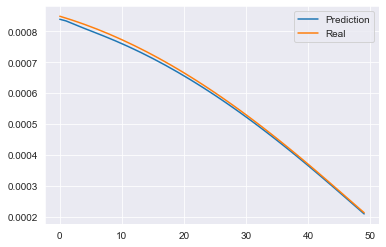

Epoch: 140, Train RMSE: 1.4601270777347963e-05, Test RMSE: 1.361165504931705e-05
Epoch: 140, Loss: 9.87111836714405e-10


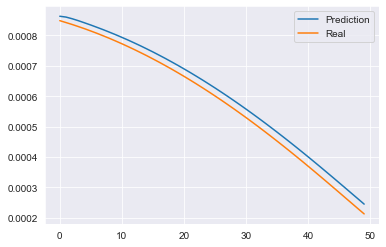

Epoch: 150, Train RMSE: 1.2005431926809251e-05, Test RMSE: 1.2397616046655457e-05
Epoch: 150, Loss: 2.3208474031477522e-10


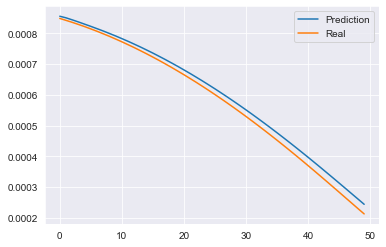

Epoch: 160, Train RMSE: 7.390756218228489e-05, Test RMSE: 7.516464393120259e-05
Epoch: 160, Loss: 4.501648831478633e-09


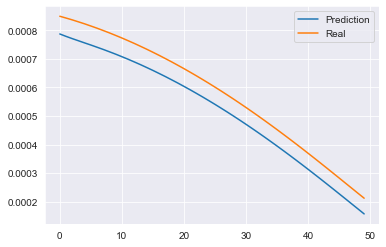

Epoch: 170, Train RMSE: 9.777454397408292e-05, Test RMSE: 9.229485294781625e-05
Epoch: 170, Loss: 6.492472670593941e-10


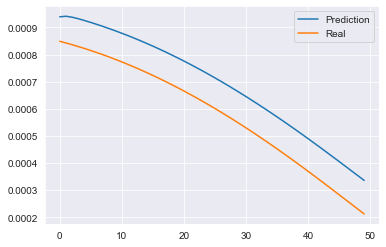

Epoch: 180, Train RMSE: 2.257049345644191e-05, Test RMSE: 2.3564451112179086e-05
Epoch: 180, Loss: 1.0307174003187924e-09


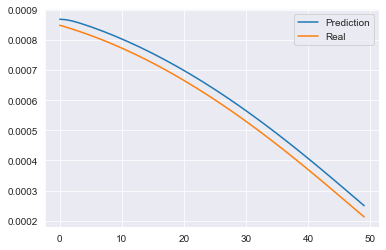

Epoch: 190, Train RMSE: 7.219194685603725e-06, Test RMSE: 8.117284778563771e-06
Epoch: 190, Loss: 3.8211524222564464e-11


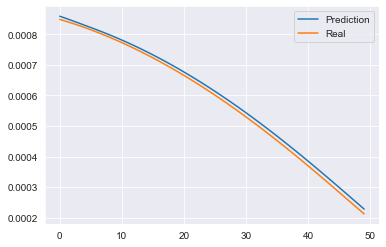

Epoch: 200, Train RMSE: 3.03323886328144e-05, Test RMSE: 3.4254539059475064e-05
Epoch: 200, Loss: 4.988208179845799e-10


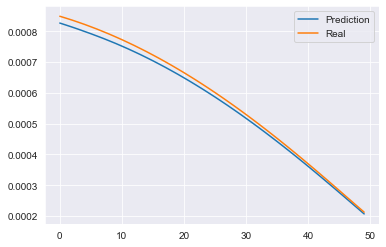

Epoch: 210, Train RMSE: 3.676742926472798e-05, Test RMSE: 3.639378701336682e-05
Epoch: 210, Loss: 1.0978640219150293e-09


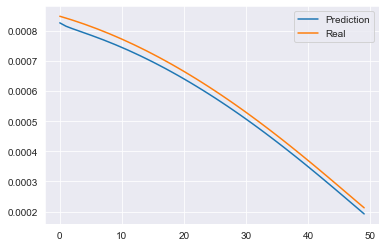

Epoch: 220, Train RMSE: 1.7806240066420287e-05, Test RMSE: 1.5290941519197077e-05
Epoch: 220, Loss: 1.7686693776219897e-10


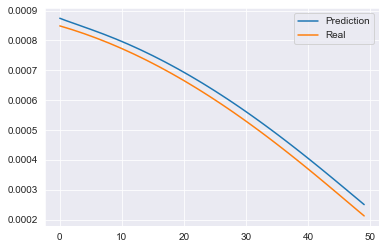

Epoch: 230, Train RMSE: 5.115429303259589e-05, Test RMSE: 5.2911487728124484e-05
Epoch: 230, Loss: 4.334060055288802e-10


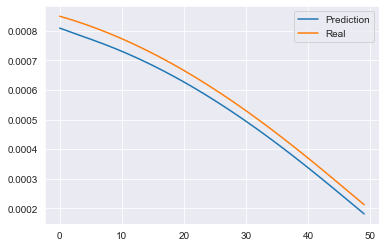

Epoch: 240, Train RMSE: 9.279178811993916e-06, Test RMSE: 9.121396942646243e-06
Epoch: 240, Loss: 1.3670248266706153e-10


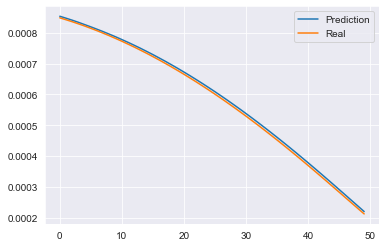

Epoch: 250, Train RMSE: 3.6934754461981356e-05, Test RMSE: 3.785204899031669e-05
Epoch: 250, Loss: 3.872395459847411e-11


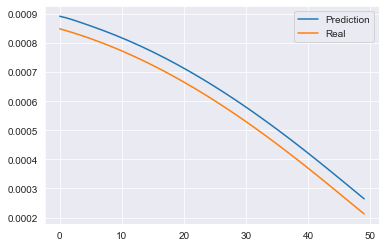

Epoch: 260, Train RMSE: 3.842334263026714e-05, Test RMSE: 4.46027479483746e-05
Epoch: 260, Loss: 4.07197775498247e-10


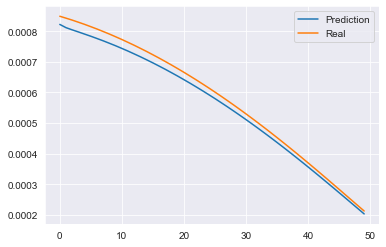

Epoch: 270, Train RMSE: 7.066792750265449e-05, Test RMSE: 6.480482261395082e-05
Epoch: 270, Loss: 2.6695976540480615e-09


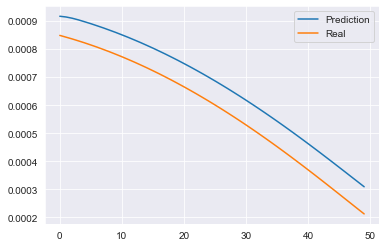

Epoch: 280, Train RMSE: 4.850433106184937e-05, Test RMSE: 5.555912866839208e-05
Epoch: 280, Loss: 2.290974493446285e-10


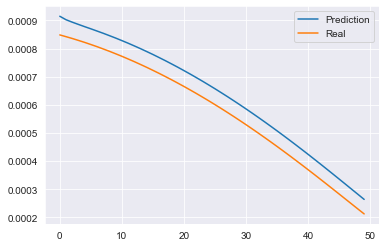

Epoch: 290, Train RMSE: 4.848949902225286e-05, Test RMSE: 4.8855115892365575e-05
Epoch: 290, Loss: 1.6972010463689458e-09


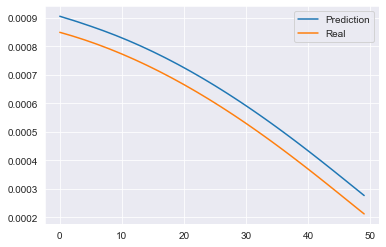

In [22]:

for epoch in range(n_epochs):
    model.train()
    for x_batch, y_batch in loader:
        y_pred = model(x_batch.float())
        loss = loss_fn(y_pred, y_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #validation
    if epoch%10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train.float())
        train_rmse = np.sqrt(loss_fn(y_pred, y_train.float()))
        y_pred = model(X_test.float())
        test_rmse = np.sqrt(loss_fn(y_pred, y_test.float()))
        print(f'Epoch: {epoch}, Train RMSE: {train_rmse}, Test RMSE: {test_rmse}')

        print(f'Epoch: {epoch}, Loss: {loss.item()}')
        plt.plot(y_pred[0].numpy(), label = 'Prediction')
        plt.plot(y_test[0].numpy(), label = 'Real')
        plt.legend()
        plt.show()
        plt.close()

## **model 2**
Multivariate network model

In [48]:
class MultiLSTM(nn.Module):
    def __init__(self, n_features, seq_len, output_size):
        super(MultiLSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_len
        self.output_size = output_size
        #pre-defined
        self.hidden_size = 50
        self.num_layers = 1

        self.lstm = nn.LSTM(input_size = self.n_features
                            ,hidden_size = self.hidden_size 
                            ,num_layers = self.num_layers,
                              batch_first = True)
        
        self.linear = nn.Linear(self.hidden_size*self.seq_len, self.output_size)

    def init_hidden(self, batch_size):
        hidden_state =  torch.zeros(self.num_layers, batch_size, self.hidden_size)
        cell_state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        self.hidden = (hidden_state, cell_state)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        x = lstm_out.contiguous().view(batch_size, -1) #flatten the output

        #x, _ = self.lstm(x) # x are the hidden states, _ is the lstm memory cell
        x = self.linear(x)
        return x

In [49]:
amplitudes =  df[['Amplitude', 'Gradient Phase']][300:31000].values
#amplitudes =  df['Amplitude'][300:31000].values
train, test = split_data(amplitudes)
X_train, y_train = create_dataset(train, 50)
X_test, y_test = create_dataset(test, 50)
#shape should be (window samples, lookback (time steps), features) 
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


torch.Size([24510, 50, 2]) torch.Size([24510, 50, 2]) torch.Size([6090, 50, 2]) torch.Size([6090, 50, 2])


In [55]:
n_features = 2
seq_len = 50
output_size = 50

#modelo
multimodel =  MultiLSTM(n_features, seq_len, output_size)
loss_fn =  nn.MSELoss()
optimizer = optim.Adam(multimodel.parameters(), lr = 0.01)

#data loader
batch_size = 16
loader = data_utils.DataLoader(data_utils.TensorDataset(X_train, y_train), shuffle = True, batch_size = batch_size)


  0%|          | 0/200 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 50, 2])) that is different to the input size (torch.Size([16, 50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([14, 50, 2])) that is different to the input size (torch.Size([14, 50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([24510, 50, 2])) that is different to the input size (torch.Size([24510, 50, 1])). This will likely lead to incorrect results

Epoch: 0, Train Loss: 0.0018875616369768977, Test Loss: 0.0016514435410499573
Epoch: 0, Loss: 0.0001111138699343428


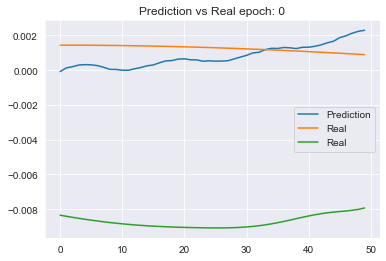

  5%|▌         | 10/200 [01:23<26:10,  8.27s/it]

Epoch: 10, Train Loss: 0.0018875616369768977, Test Loss: 0.0016514435410499573
Epoch: 10, Loss: 0.00016658160893712193


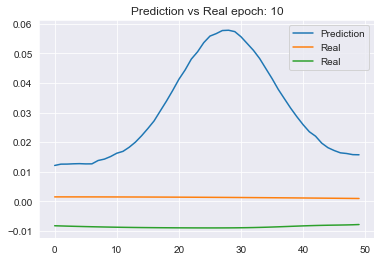

 10%|█         | 20/200 [02:44<23:24,  7.80s/it]

Epoch: 20, Train Loss: 0.0018875616369768977, Test Loss: 0.0016514435410499573
Epoch: 20, Loss: 0.00023421911464538425


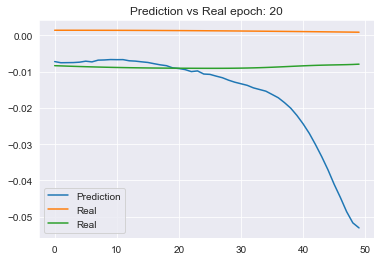

 15%|█▌        | 30/200 [04:04<22:20,  7.89s/it]

Epoch: 30, Train Loss: 0.0018875616369768977, Test Loss: 0.0016514435410499573
Epoch: 30, Loss: 2.307765680598095e-05


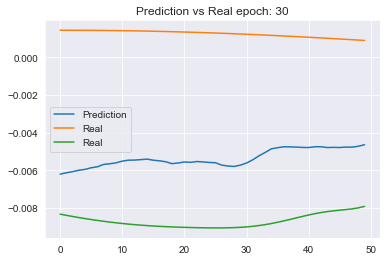

 20%|██        | 40/200 [05:22<19:51,  7.45s/it]

Epoch: 40, Train Loss: 0.0018875616369768977, Test Loss: 0.0016514435410499573
Epoch: 40, Loss: 0.0004971557063981891


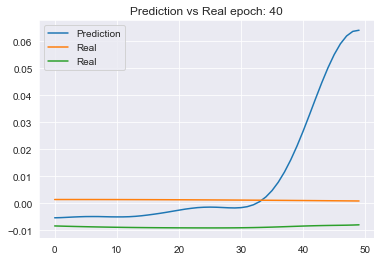

 20%|██        | 41/200 [05:32<21:21,  8.06s/it]

In [61]:
train_losses = []
test_losses = []

n_epochs = 200
for epoch in tqdm(range(n_epochs)):
    multimodel.train()
    for x_batch, y_batch in loader:
        
        multimodel.init_hidden(x_batch.size(0))

        y_pred = multimodel(x_batch.float())
        #print(y_pred.shape, y_batch.shape)
        loss = loss_fn(y_pred.unsqueeze(2), y_batch.float())
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        
    
    #validation
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            y_pred_train = model(X_train.float())
            train_loss = loss_fn(y_pred_train, y_train.float())
            train_losses.append(train_loss.item())
            
            y_pred_test = model(X_test.float())
            test_loss = loss_fn(y_pred_test, y_test.float())
            test_losses.append(test_loss.item())
            
            print(f'Epoch: {epoch}, Train Loss: {train_loss.item()}, Test Loss: {test_loss.item()}')
            print(f'Epoch: {epoch}, Loss: {loss.item()}')
            plt.plot(y_pred[0].numpy(), label = 'Prediction')
            plt.plot(y_test[0].numpy(), label = 'Real')
            plt.title('Prediction vs Real epoch: ' + str(epoch))
            plt.legend()
            plt.show()
            plt.close()
            
    
    if epoch % 50 == 0 and epoch != 0:
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.title('Losses train vs test epoch: ' + str(epoch))
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
        plt.close()